# Flexible input shapes for custom layers
In this reading you will learn how to use the build method to allow custom layers to work with flexible sized inputs.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0


## Fix the input shape in the custom layer

Previously, you have created custom layers by initialising all variables in the `__init__` method. For instance, you defined a dense layer called `MyLayer` as follows:

In [2]:
# Create a custom layer

from tensorflow.keras.layers import Layer

class MyLayer(Layer):

    def __init__(self, units, input_dim, **kwargs):
        super(MyLayer, self).__init__(**kwargs)
        self.w = self.add_weight(shape=(input_dim, units),
                             initializer='random_normal')
        self.b = self.add_weight(shape=(units,),
                             initializer='zeros')
        
    def call(self, inputs):
        return tf.matmul(inputs, self.w)+self.b

Notice that the required arguments for the `__init__` method are the number of units in the dense layer (`units`) and the input size (`input_dim`). This means that you need to fix these two arguments when you instantiate the layer.

In [3]:
#  Create a custom layer with 3 units and input dimension of 5

dense_layer = MyLayer(3, 5) 

Since the input size has been fixed to be 5, this custom layer can only take inputs of that size. For example, we can call the layer as follows:

In [7]:
# Call the custom layer on a Tensor input of ones

x = tf.ones((1,5))
print(dense_layer(x))

tf.Tensor([[-0.01742738  0.26001152  0.06140336]], shape=(1, 3), dtype=float32)


However, forcing the input shape (and therefore the shape of the weights) to be fixed when the layer is instantiated is unnecessary, and it may be more convenient to only do this later on, after the model has been defined. 

For example, in some cases you may not know the input shape at the model building time. We have come across this concept before when building models with the Sequential API. If the `input_shape` argument is omitted, the weights will only be created when an input is passed into the model.

## Allow a flexible input shape in the custom layer

You can delay the weight creation by using the `build` method to define the weights. The `build` method is executed when the `__call__` method is called, meaning the weights are only created only the layer is called with a specific input.

The `build` method has a required argument `input_shape`, which can be used to define the shapes of the layer weights.

In [8]:
# Rewrite the custom layer with lazy weight creation

class MyLayer(Layer):

    def __init__(self, units, **kwargs):
        super(MyLayer, self).__init__(**kwargs)
        self.units = units
    
    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal')
        self.b = self.add_weight(shape=(self.units,),
                                 initializer='zeros')
    def call(self, inputs):
        return tf.matmul(inputs, self.w)+self.b

Now, when you instantiate the layer, you only need to specify the number of units in the dense layer (`units`), and not the input size (`input_dim`).

### Create a custom layer with flexible input size

In [17]:
#  Create a custom layer with 3 units

dense_layer = MyLayer(3) 

This layer can now be called on an input of any size, at which point the layer weights will be created and the input size will be fixed.

In [19]:
# Call the custom layer on a Tensor input of ones of size 5

x = tf.ones((1,5))
print(dense_layer(x))

tf.Tensor([[0.10938657 0.09594828 0.11255987]], shape=(1, 3), dtype=float32)


In [36]:
# Print the layer weights

dense_layer.weights[0].numpy()

array([[-0.00935363,  0.04585981,  0.06239241],
       [ 0.06676051,  0.04016985,  0.00821654],
       [ 0.03934013,  0.11005535,  0.03822603],
       [ 0.00929175, -0.03567433, -0.00413562],
       [ 0.00334782, -0.06446239,  0.0078605 ]], dtype=float32)

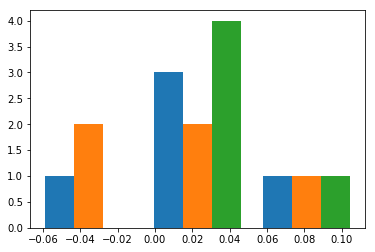

In [43]:
import matplotlib.pyplot as plt
plt.hist(dense_layer.weights[0].numpy(),bins=3)
plt.show()

### Create a new custom layer and pass in a different sized input

In [44]:
#  Create a new custom layer with 3 units

dense_layer = MyLayer(3) 

In [45]:
# Call the custom layer on a Tensor input of ones of size 4

x = tf.ones((1,4))
print(dense_layer(x))

tf.Tensor([[ 0.07619953 -0.01767136  0.08804207]], shape=(1, 3), dtype=float32)


In [48]:
# Print the layer weights

dense_layer.weights

[<tf.Variable 'my_layer_4/Variable:0' shape=(4, 3) dtype=float32, numpy=
 array([[ 0.05449088,  0.07858971,  0.01231421],
        [-0.01319209, -0.07972506, -0.0898177 ],
        [-0.01247917,  0.00485023,  0.13662814],
        [ 0.04737991, -0.02138623,  0.02891743]], dtype=float32)>,
 <tf.Variable 'my_layer_4/Variable:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]

Note that the code for creating a custom layer object is identical, but the shape of the weights in the layer depend on the size of the input passed to the layer.

## Flexible input shapes in models

Deferring the weight creation until the layer is called is also useful when using the custom layer as an intermediate layer inside a larger model. In this case you may want to create several custom layer objects in the model, and it is tedious to keep track of the input shape that each of the custom layers needs. 

By deferring the weight creation as above, the input shape can be inferred from the output of the previous layer.

In [49]:
# Create a model using the custom layer

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Softmax

class MyModel(Model):

    def __init__(self, units_1, units_2, **kwargs):
        super(MyModel, self).__init__(**kwargs)
        self.layer_1 = MyLayer(units_1)
        self.layer_2 = MyLayer(units_2)

    def call(self, inputs):
        x = self.layer_1(inputs)
        x = tf.nn.relu(x)
        x = self.layer_2(x)
        return Softmax()(x)

In the above model definition, the custom layer `MyLayer` is used twice. Notice that each instance of the custom layer object can have a different input size, depending on the arguments used to create the model and the inputs passed into the model

In [50]:
# Create a custom model object

model = MyModel(units_1=32, units_2=10)

We can create and initialise all of the weights of the model by passing in an example Tensor input.

In [51]:
# Create and initialize all of the model weights

_ = model(tf.ones((1, 100)))

In [52]:
# Print the model summary

model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_layer_5 (MyLayer)         multiple                  3232      
_________________________________________________________________
my_layer_6 (MyLayer)         multiple                  330       
Total params: 3,562
Trainable params: 3,562
Non-trainable params: 0
_________________________________________________________________


## Further reading and resources 
* https://www.tensorflow.org/guide/keras/custom_layers_and_models#best_practice_deferring_weight_creation_until_the_shape_of_the_inputs_is_known